In [1]:
import json as js
import numpy as np
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import string
from collections import defaultdict, OrderedDict
from nltk.stem.snowball import PortugueseStemmer
from nltk.corpus import wordnet, stopwords
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from collections import Counter, OrderedDict
import itertools
from gensim import corpora, models, similarities
import whoosh
from whoosh.fields import *
from whoosh.qparser import QueryParser
from whoosh.index import create_in, open_dir
import os
import seaborn as sns
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.fasttext import FastText as FT_gensim
from gensim.test.utils import datapath

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, word2vec

# Fonte dos dados utilizados: https://www.kaggle.com/jorgefjr/brazilian-songs-lyrics

Carregando as letras

In [2]:
data_axe = pd.read_csv('letras_mus_br_axe.csv', usecols=['titulo','artista','letras'])
data_bossa = pd.read_csv('letras_mus_br_bossa-nova.csv', usecols=['titulo','artista','letras'])
data_forro = pd.read_csv('letras_mus_br_forro.csv', usecols=['titulo','artista','letras'])
data_funk = pd.read_csv('letras_mus_br_funk.csv', usecols=['titulo','artista','letras'])
data_gospel = pd.read_csv('letras_mus_br_gospel.csv', usecols=['titulo','artista','letras'])
data_pagode = pd.read_csv('letras_mus_br_pagode.csv', usecols=['titulo','artista','letras'])
data_samba = pd.read_csv('letras_mus_br_samba.csv', usecols=['titulo','artista','letras'])
data_sertanejo = pd.read_csv('letras_mus_br_sertanejo.csv', usecols=['titulo','artista','letras'])

data_axe['genero'] = 'axe'
data_bossa['genero'] = 'bossa'
data_forro['genero'] = 'forro'
data_funk['genero'] = 'funk'
data_gospel['genero'] = 'gospel'
data_pagode['genero'] = 'pagode'
data_samba['genero'] = 'samba'
data_sertanejo['genero'] = 'sertanejo'

In [3]:
full_data = pd.concat([data_axe,
                       data_bossa,
                       data_forro,
                       data_funk,
                       data_gospel,
                       data_pagode,
                       data_samba, 
                       data_sertanejo], axis=0).reset_index()[['titulo','artista','letras', 'genero']]

full_data.rename(columns={'letras':'letra'}, inplace=True)

In [4]:
full_data.head()

,titulo,artista,letra,genero
0,10 Beijos de Rua,Léo Santana,Acabou outra vez. Foi cena repetida. Um tchau...,axe
1,Quando a Chuva Passar,Ivete Sangalo,Pra que falar. Se você não quer me ouvir. Fug...,axe
2,Anjo,Saulo Fernandes,Hoje eu acordei mais cedo. E fiquei te olhand...,axe
3,O Que Seria,Carlinhos Brown,Quem sabe nem era pra ser nossa. Aquela lua a...,axe
4,Um Sinal (part. Melim),Ivete Sangalo,Eu jamais quis deixar você ir. Mas quem de nó...,axe


Carregando stopwords e pontuação

In [5]:
pontuacao = list(string.punctuation)
lixo = stopwords.words('portuguese') + pontuacao + ['..', ',.', '..', '...', '....', '.....', ')', '('] 
stemmer = PortugueseStemmer()

Preparando as letras

In [6]:
letras = [letra for letra in list(full_data['letra'])]
letras_limpas = []
tokenizador = WordPunctTokenizer()

# limpando
for letra in letras:
    l_limpa = [stemmer.stem(token.lower()) for token in tokenizador.tokenize(letra) if token not in lixo]
    letras_limpas.append(l_limpa)

In [7]:
letras_limpas[20][:10]

['por',
 'onde',
 'floresc',
 'seren',
 'águ',
 'poc',
 'risqu',
 'palavr',
 'fei',
 'e']

# Indexação

Construindo uma função de busca.

In [8]:
indice_frase = defaultdict(lambda: defaultdict(list))

for text_id, text in enumerate(letras_limpas):
    for token_id, token in enumerate(text):
        indice_frase[token][text_id].append(token_id)
        

def aux_procura_trecho(frase, index):
    tokens = [stemmer.stem(token.strip(string.punctuation + " "+"").lower()) for token in WordPunctTokenizer().tokenize(frase) if token not in lixo]
     
    matches = defaultdict(lambda:defaultdict(lambda:set([])))
    for token in tokens:
        matches[token] = index[token]
    
    documents = set(matches[tokens[0]])
    for token in tokens:
        documents = documents.intersection(set(matches[token]))
    
    res = set([]) 
    for doc in documents:
        for pos in matches[tokens[0]][doc]:
            if all((pos + token_id + 1 in matches[token][doc]) for token_id, token in enumerate(tokens[1:len(tokens)])):
                res.add(doc) 
                
    return res


def procura_trecho(frase):
        
    tokens = [stemmer.stem(token.strip(string.punctuation + " "+"").lower()) for token in WordPunctTokenizer().tokenize(frase) if token not in lixo]
 
    res = aux_procura_trecho(frase, indice_frase)
    
    if res == set([]):
        searcher = ix.searcher()
        query = QueryParser("content", ix.schema).parse(frase)
        new_res = searcher.search(query)
        return new_res.docs()
    else:
        return res
    

def printa_musicas(frase):
    resultado = procura_trecho(frase)
    c = 0
    for i in resultado:
        print(c+1,')','"',full_data.titulo[i],'"','\n',full_data.letra[i],'\n')
        c += 1
        
        if c == 10:
            break



Exemplo de uso da função de busca:

In [9]:
printa_musicas('cerveja')

1 ) " Meu Coração Deu PT (part. Matheus e Kauan) " 
  Pegar meu violão. Um copo, uma cerveja. Um whisky e um cigarro. Eu não tô nada bem. Vi minha ex beijando. Outro dentro do carro. Não sei por que me ligou. Com saudade, chorando. Carente, implorando, querendo voltar. Eu não fiquei com ninguém. Te esperando, confiei demais. Me enganei de novo, quebrei a cara. Mais uma vez, eu tomei porre por você. Mais uma vez, o meu coração deu PT. A culpa é sua. Se eu tô aqui jogado no meio da rua. Me deixa aqui sofrendo. Eu não quero ajuda. Eu fui tão inocente por acreditar. Que ainda me amava. E agora fala. Que droga de amor é esse que sentia. Ontem eu era o amor da sua vida. E hoje eu sou o quê. E hoje eu sou o quê. Hoje eu sou passado pra você.   

2 ) " Festa de Vaquejada " 
  Dá pra ver de longe que tem vaquejada. A poeira sobe e o chicote estrala. Mulher pra todo lado de bota e chapéu. Tem loira e tem morena dos olhos cor de mel. Locutor chamando pra correr o gado. Vaqueiro bebendo, cavalo se

# Modelagem de assuntos

## Construindo um modelo LSI

In [12]:
dic = corpora.Dictionary(letras_limpas)
corpus = [dic.doc2bow(line) for line in letras_limpas]
tfidf = models.TfidfModel(corpus)

In [13]:
corpus_tfidf = tfidf[corpus]

In [14]:
lsi = models.LsiModel(corpus_tfidf,
                      id2word=dic,
                      num_topics=8)

corpus_lsi = lsi[corpus_tfidf]

A justificativa para o número de tópicos ser igual a 8 baseia-se no fato de que, na verdade, estamos trabalhando com a junção de 8 conjuntos de dados, cada um contendo letras de um gênero musical específico. Por conta disso, arbitrariamente fiz o número de assuntos ser igual a 8 para verificar se conseguimos identificar claramente os 8 gêneros musicais aqui existentes.

In [15]:
lsi.show_topics(8,5)

[(0, '0.150*"amor" + 0.131*"quer" + 0.131*"eu" + 0.128*"vou" + 0.121*"vai"'),
 (1,
  '-0.396*"deus" + -0.309*"ele" + -0.270*"senhor" + -0.212*"jesus" + -0.178*"ti"'),
 (2, '0.325*"ai" + 0.221*"samb" + 0.218*"tá" + -0.189*"amo" + 0.167*"vai"'),
 (3, '-0.369*"samb" + 0.268*"ele" + 0.195*"deus" + 0.179*"tô" + -0.173*"mar"'),
 (4, '0.840*"ai" + -0.244*"samb" + 0.119*"oh" + -0.111*"vai" + 0.103*"ti"'),
 (5, '-0.273*"oh" + 0.269*"ele" + 0.249*"ai" + 0.229*"deus" + -0.190*"ti"'),
 (6, '-0.399*"i" + -0.347*"the" + -0.339*"you" + -0.197*"and" + -0.190*"to"'),
 (7,
  '-0.626*"samb" + -0.159*"vou" + -0.156*"ai" + -0.146*"senhor" + 0.136*"mar"')]

In [16]:
data = {i: OrderedDict(lsi.show_topic(i,8)) for i in range(8)}

In [17]:
df_corpus_dic = pd.DataFrame(data)
df_corpus_dic = df_corpus_dic.fillna(0).T

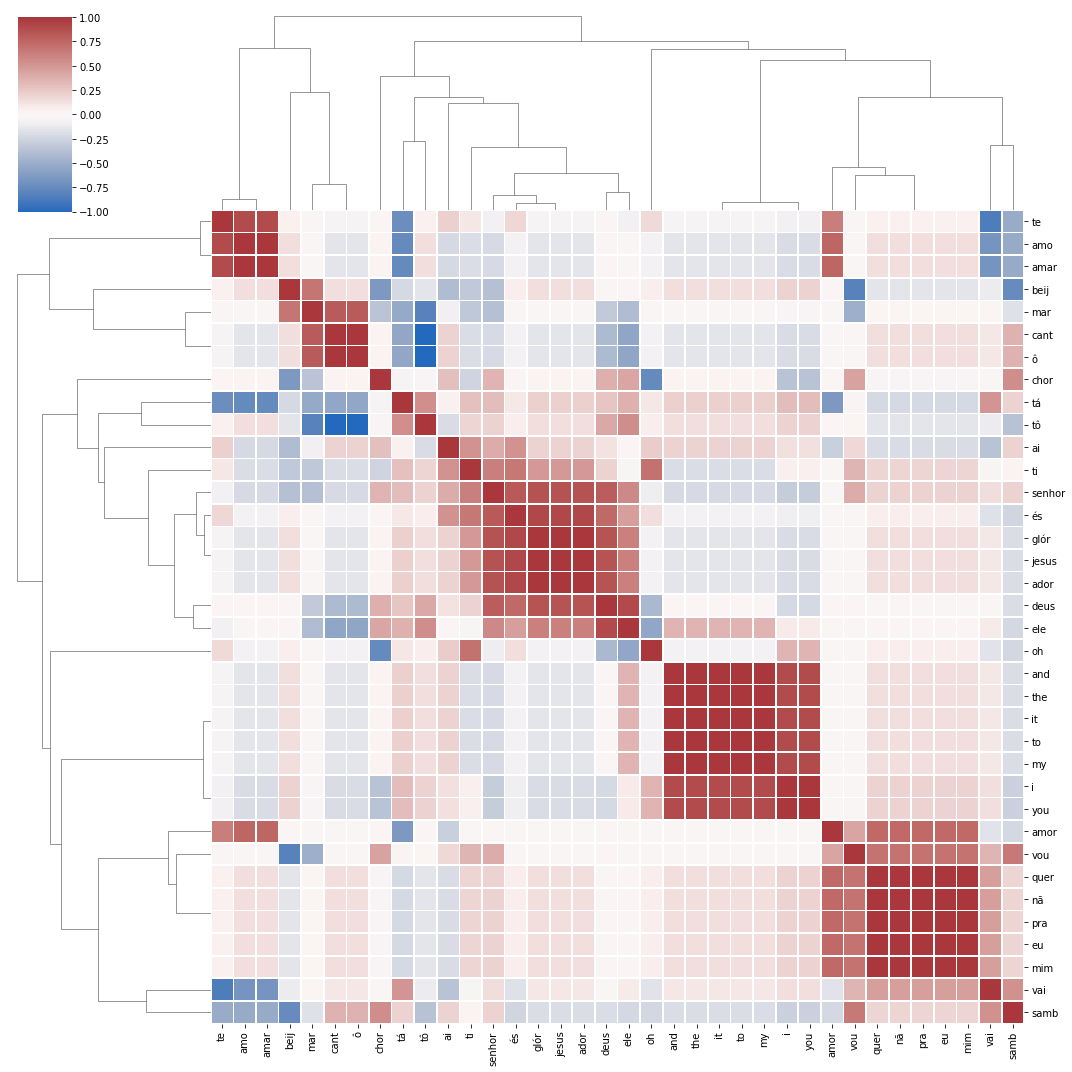

In [18]:
sns.clustermap(df_corpus_dic.corr(), 
               center=0, 
               cmap="vlag", 
               metric='cosine',
               linewidths=.75, 
               figsize=(15, 15))

Vemos acima uma certa quantidade de palavras em outras línguas como inglês e espanhol, embora estejamos tratando apenas de músicas brasileiras. Considerei a possibilidade de retirar essas músicas da análise, no entanto, acredito que a presença de palavras em línguas estrangeiras represente um aspecto importante de certos gêneros musicais. Assim, esta característica será de grande ajuda posteriormente, quando formos treinar um modelo de classificação dos gêneros das canções a partir de suas letras.

## Construindo um modelo LDA

In [19]:
lda_model = models.ldamodel.LdaModel(corpus, 
                                     id2word=dic, 
                                     num_topics=8, 
                                     passes=10)

In [20]:
lda_model.show_topics()

[(0,
  '0.027*"e" + 0.016*"amor" + 0.016*"que" + 0.015*"a" + 0.015*"o" + 0.011*"cant" + 0.011*"mar" + 0.010*"é" + 0.008*"céu" + 0.007*"vem"'),
 (1,
  '0.041*"i" + 0.028*"you" + 0.027*"the" + 0.017*"to" + 0.014*"s" + 0.013*"lov" + 0.013*"it" + 0.013*"and" + 0.012*"my" + 0.011*"in"'),
 (2,
  '0.029*"pra" + 0.024*"eu" + 0.021*"amor" + 0.020*"e" + 0.019*"quer" + 0.013*"nã" + 0.013*"vou" + 0.012*"que" + 0.010*"faz" + 0.010*"mas"'),
 (3,
  '0.031*"la" + 0.018*"y" + 0.011*"el" + 0.011*"mi" + 0.009*"un" + 0.009*"en" + 0.009*"le" + 0.008*"yo" + 0.008*"si" + 0.007*"que"'),
 (4,
  '0.035*"ai" + 0.025*"samb" + 0.024*"lá" + 0.018*"ô" + 0.018*")." + 0.017*"oh" + 0.015*"vou" + 0.010*"dá" + 0.009*"prá" + 0.008*"o"'),
 (5,
  '0.020*"pra" + 0.017*"sent" + 0.017*"vai" + 0.016*"é" + 0.014*"tá" + 0.013*"tô" + 0.012*"cê" + 0.009*"fal" + 0.009*"lig" + 0.008*"e"'),
 (6,
  '0.035*"deus" + 0.017*"senhor" + 0.016*"ele" + 0.013*"e" + 0.013*"eu" + 0.012*"o" + 0.011*"pod" + 0.010*"jesus" + 0.010*"pra" + 0.009*"ti"'

In [21]:
corpus_lda = lda_model[corpus]
data_lda = {i: OrderedDict(lda_model.show_topic(i,8)) for i in range(8)}

In [22]:
df_corpus_dic_lda = pd.DataFrame(data_lda)
df_corpus_dic_lda = df_corpus_dic_lda.fillna(0).T

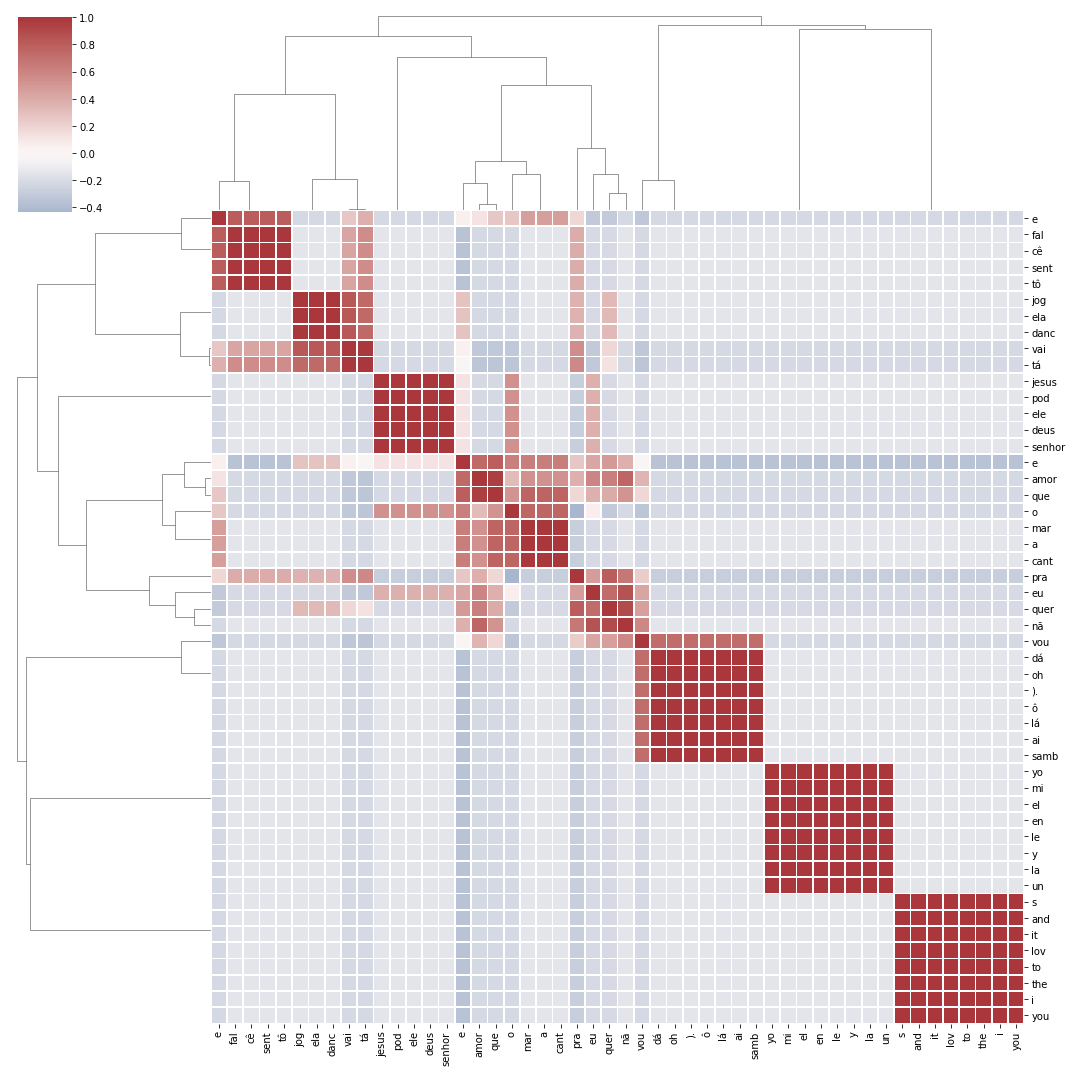

In [23]:
sns.clustermap(df_corpus_dic_lda.corr(), 
               center=0, 
               cmap="vlag", 
               metric='cosine',
               linewidths=.75, 
               figsize=(15, 15))

# Classificação de gêneros musicais

## Modelo binário

Para começar, vou tentar classificar as letras em "gospel" ou "funk", gêneros que parecem bem distantes entre si em termos de letra. Por isso, teremos que modificar nosso dataframe original e realizar todo o pré-processamento novamente.

In [24]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec, word2vec

import spacy
from spacy import displacy

import time

In [32]:
df_model_1 = full_data[(full_data.genero == 'funk') | (full_data.genero == 'gospel')]
df_model_1['genero_bin'] = df_model_1['genero'].map({'funk':0, 'gospel':1})
df_model_1 = df_model_1.reset_index()

<ipython-input-32-3e0b817c6628>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_1['genero_bin'] = df_model_1['genero'].map({'funk':0, 'gospel':1})


In [34]:
df_model_1.head()

,index,titulo,artista,letra,genero,genero_bin
0,3000,O Bebê (part. MC Kekel),Kevinho,Alô. Por que você não me atendeu. Já tava mó ...,funk,0
1,3001,A Distância Tá Maltratando (part. MC G15),MC Bruninho,Como é que tá aí. Já se acostumou com a cidad...,funk,0
2,3002,Mete Com Força e Com Talento,MC Nick,Mete com força e com talento. Estou ofegante ...,funk,0
3,3003,Sou Favela (part. Vitinho Ferrari),MC Bruninho,Rodo becos e viela. Mas não encontrei ninguém...,funk,0
4,3004,Amor de Verdade (part. MC Kekel),MC Rita,"Espera aí. Preciso tanto conversar. Então, ve...",funk,0


### Tokenização

In [35]:
df_model_1['letra_tokenizada'] = [simple_preprocess(line, deacc=True) for line in df_model_1['letra']] 
df_model_1.head()

,index,titulo,artista,letra,genero,genero_bin,letra_tokenizada
0,3000,O Bebê (part. MC Kekel),Kevinho,Alô. Por que você não me atendeu. Já tava mó ...,funk,0,"[alo, por, que, voce, nao, me, atendeu, ja, ta..."
1,3001,A Distância Tá Maltratando (part. MC G15),MC Bruninho,Como é que tá aí. Já se acostumou com a cidad...,funk,0,"[como, que, ta, ai, ja, se, acostumou, com, ci..."
2,3002,Mete Com Força e Com Talento,MC Nick,Mete com força e com talento. Estou ofegante ...,funk,0,"[mete, com, forca, com, talento, estou, ofegan..."
3,3003,Sou Favela (part. Vitinho Ferrari),MC Bruninho,Rodo becos e viela. Mas não encontrei ninguém...,funk,0,"[rodo, becos, viela, mas, nao, encontrei, ning..."
4,3004,Amor de Verdade (part. MC Kekel),MC Rita,"Espera aí. Preciso tanto conversar. Então, ve...",funk,0,"[espera, ai, preciso, tanto, conversar, entao,..."


In [36]:
port_stemmer = PortugueseStemmer()
df_model_1['stemmed_tokens'] = [[port_stemmer.stem(word) for word in tokens] for tokens in df_model_1['letra_tokenizada'] ]
df_model_1.head(10)

,index,titulo,artista,letra,genero,genero_bin,letra_tokenizada,stemmed_tokens
0,3000,O Bebê (part. MC Kekel),Kevinho,Alô. Por que você não me atendeu. Já tava mó ...,funk,0,"[alo, por, que, voce, nao, me, atendeu, ja, ta...","[alo, por, que, voc, nao, me, atend, ja, tav, ..."
1,3001,A Distância Tá Maltratando (part. MC G15),MC Bruninho,Como é que tá aí. Já se acostumou com a cidad...,funk,0,"[como, que, ta, ai, ja, se, acostumou, com, ci...","[com, que, ta, ai, ja, se, acostum, com, cidad..."
2,3002,Mete Com Força e Com Talento,MC Nick,Mete com força e com talento. Estou ofegante ...,funk,0,"[mete, com, forca, com, talento, estou, ofegan...","[met, com, forc, com, talent, estou, ofeg, voc..."
3,3003,Sou Favela (part. Vitinho Ferrari),MC Bruninho,Rodo becos e viela. Mas não encontrei ninguém...,funk,0,"[rodo, becos, viela, mas, nao, encontrei, ning...","[rod, bec, viel, mas, nao, encontr, ningu, que..."
4,3004,Amor de Verdade (part. MC Kekel),MC Rita,"Espera aí. Preciso tanto conversar. Então, ve...",funk,0,"[espera, ai, preciso, tanto, conversar, entao,...","[esper, ai, precis, tant, convers, enta, vem, ..."
5,3005,Vou Buscar,MC Hariel,Tô distante de perreco há mó tempão. Os trata...,funk,0,"[to, distante, de, perreco, ha, mo, tempao, os...","[to, distant, de, perrec, ha, mo, tempa, os, t..."
6,3006,Pra Inveja é Tchau (part. MC Kevin),MC Davi,Fica o dia inteiro falando da minha vida. Cri...,funk,0,"[fica, dia, inteiro, falando, da, minha, vida,...","[fic, dia, inteir, fal, da, minh, vid, critic,..."
7,3007,Jogo do Amor,MC Bruninho,"Olha aonde eu vim parar. Mais uma vez, o cora...",funk,0,"[olha, aonde, eu, vim, parar, mais, uma, vez, ...","[olha, aond, eu, vim, par, mais, uma, vez, cor..."
8,3008,Só Você (part. MC G15),Dennis DJ,Para pra pensar se a gente é acidente. Se foi...,funk,0,"[para, pra, pensar, se, gente, acidente, se, f...","[par, pra, pens, se, gent, acident, se, foi, p..."
9,3009,Sou Favela,Aldair Playboy,Rodo becos e vielas. E não encontrei ninguém....,funk,0,"[rodo, becos, vielas, nao, encontrei, ninguem,...","[rod, bec, viel, nao, encontr, ningu, que, ten..."


### Definição dos conjuntos de treino e teste

In [38]:
def split_train_test(df, 
                     features=['titulo','artista','letra','letra_tokenizada','stemmed_tokens'],
                     target='genero_bin',
                     test_size=0.3, 
                     shuffle_state=True):
    
    X_train, X_test, Y_train, Y_test = train_test_split(df[features], 
                                                        df[target], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    
    print("Contando os valores para os generos do conjunto de treino:")
    print(Y_train.value_counts())
    print("Contando os valores para os generos do conjunto de teste:")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    
    return X_train, X_test, Y_train, Y_test


X_train, X_test, Y_train, Y_test = split_train_test(df_model_1)

Contando os valores para os generos do conjunto de treino:
0    707
1    693
Name: genero_bin, dtype: int64
Contando os valores para os generos do conjunto de teste:
1    307
0    293
Name: genero_bin, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


### Word2Vec

In [40]:
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1

OUTPUT_FOLDER = 'output_folder'

word2vec_gospelfunk_file = OUTPUT_FOLDER + '/' + 'gospel_funk_' + 'word2vec_' + str(size) + '.model'
start_time = time.time()
stemmed_tokens = pd.Series(df_model_1['stemmed_tokens']).values

# treinando o Word2Vec
w2v_gospelfunk_model = Word2Vec(stemmed_tokens, 
                                 min_count = min_count, 
                                 size = size, 
                                 workers = workers, 
                                 window = window, 
                                 sg = sg)

print("Tempo para treinar o word2vec: ", str(time.time() - start_time), 'segundos')
w2v_gospelfunk_model.save(word2vec_gospelfunk_file)

Tempo para treinar o word2vec:  23.612053155899048 segundos


Carregando o modelo já treinado e acessando seu dicionário:

In [41]:
sg_w2v_gospelfunk_model = Word2Vec.load(word2vec_gospelfunk_file)

# index de uma palavra
print("Index da palavra 'deus':", sg_w2v_gospelfunk_model.wv.vocab["deus"].index)

print('Número total de palavras:',len(sg_w2v_gospelfunk_model.wv.vocab))

print("Tamanho do vetor gerado por uma palavra:", len(sg_w2v_gospelfunk_model['deus']))

Index da palavra 'deus': 17
Número total de palavras: 9683
Tamanho do vetor gerado por uma palavra: 1000


<ipython-input-41-e9fdc684c006>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print("Tamanho do vetor gerado por uma palavra:", len(sg_w2v_gospelfunk_model['deus']))


Gerando vetores Word2Vec:

In [43]:
word2vec_gospelfunk_filename = OUTPUT_FOLDER + '/' + 'train_review_gospelfunk_word2vec.csv'
with open(word2vec_gospelfunk_filename, 'w+') as word2vec_gospelfunk_file:
    for index, row in X_train.iterrows():
        model_vector = (np.mean([sg_w2v_gospelfunk_model[token] for token in row['stemmed_tokens']], 
                                axis=0)).tolist()
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_gospelfunk_file.write(header)
            word2vec_gospelfunk_file.write("\n")
        
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(1000)])
        word2vec_gospelfunk_file.write(line1)
        word2vec_gospelfunk_file.write('\n')

<ipython-input-43-e15fbf2e48e2>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  model_vector = (np.mean([sg_w2v_gospelfunk_model[token] for token in row['stemmed_tokens']],


### Treinando o modelo de classificação usando vetores Word2Vec

In [44]:
# carregando do arquivo
word2vec_gospelfunk_df = pd.read_csv(word2vec_gospelfunk_filename)

# inicializando o modelo
clf_rf_word2vec = RandomForestClassifier(criterion='entropy')

start_time = time.time()
# fitando o modelo
clf_rf_word2vec.fit(word2vec_gospelfunk_df, Y_train['genero_bin'])
print("Tempo levado para fitar o modelo a partir dos vetores word2vec: " + str(time.time() - start_time))

Tempo levado para fitar o modelo a partir dos vetores word2vec: 1.81646728515625


### Testando o modelo de classificação

In [45]:
from sklearn import model_selection

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

In [47]:
# função de avaliação de modelo que roubei do Renato :)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clf_eval(clf, X, y_true, classes=['0', '1']):
    y_pred = clf.predict(X)
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred, average='weighted')))
    plot_confusion_matrix(clf_matrix, classes=classes)
    
    if len(classes) == 2:
        print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
        print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
        return roc_auc_score(y_true, y_pred)

In [49]:
test_features_gospelfunk_word2vec = []
for index, row in X_test.iterrows():
    model_vector = np.mean([sg_w2v_gospelfunk_model[token] for token in row['stemmed_tokens']], axis=0)
    test_features_gospelfunk_word2vec.append(model_vector)

<ipython-input-49-5bcfae85b94a>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  model_vector = np.mean([sg_w2v_gospelfunk_model[token] for token in row['stemmed_tokens']], axis=0)


Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       293
           1       0.97      0.96      0.97       307

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

Accuracy Score: 0.9666666666666667
f1 Score: 0.9666703713994628
Confusion matrix, without normalization
[[285   8]
 [ 12 295]]
ROC Score: 0.9668041489255261
Average Precision Score: 0.9555414368798444


0.9668041489255261

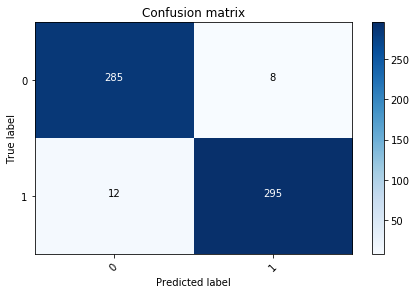

In [50]:
clf_eval(clf_rf_word2vec,
         test_features_gospelfunk_word2vec, 
         Y_test['genero_bin'])

## Modelo multiclass

Como obtivemos um excelente resultado para classificação de letras de canções em gospel ou funk, ajustaremos um outro modelo que leve em consideração todos os gêneros presentes em nosso dataset.

### Tokenização

In [52]:
data_model = full_data.copy()
genero_map_dict = {'gospel':0,
                   'sertanejo':1,
                   'axe':2, 
                   'forro':3, 
                   'pagode':4, 
                   'samba':5, 
                   'bossa':6,
                   'funk':7}

data_model['genero_num'] = data_model['genero'].map(genero_map_dict)

data_model['letra_tokenizada'] = [simple_preprocess(line, deacc=True) for line in data_model['letra']] 
data_model.head(n=10)

,titulo,artista,letra,genero,genero_num,letra_tokenizada
0,10 Beijos de Rua,Léo Santana,Acabou outra vez. Foi cena repetida. Um tchau...,axe,2,"[acabou, outra, vez, foi, cena, repetida, um, ..."
1,Quando a Chuva Passar,Ivete Sangalo,Pra que falar. Se você não quer me ouvir. Fug...,axe,2,"[pra, que, falar, se, voce, nao, quer, me, ouv..."
2,Anjo,Saulo Fernandes,Hoje eu acordei mais cedo. E fiquei te olhand...,axe,2,"[hoje, eu, acordei, mais, cedo, fiquei, te, ol..."
3,O Que Seria,Carlinhos Brown,Quem sabe nem era pra ser nossa. Aquela lua a...,axe,2,"[quem, sabe, nem, era, pra, ser, nossa, aquela..."
4,Um Sinal (part. Melim),Ivete Sangalo,Eu jamais quis deixar você ir. Mas quem de nó...,axe,2,"[eu, jamais, quis, deixar, voce, ir, mas, quem..."
5,Se Eu Não Te Amasse Tanto Assim,Ivete Sangalo,"Meu coração, sem direção. Voando só por voar....",axe,2,"[meu, coracao, sem, direcao, voando, so, por, ..."
6,O Mais Belo Dos Belos,Daniela Mercury,Quem é que sobe a ladeira do Curuzu. E a cois...,axe,2,"[quem, que, sobe, ladeira, do, curuzu, coisa, ..."
7,Eva,Banda Eva,"Meu amor, olha só, hoje o sol não apareceu. É...",axe,2,"[meu, amor, olha, so, hoje, sol, nao, apareceu..."
8,Flor do Reggae,Ivete Sangalo,Um brilho de amor chegou. Na ilha inteira. E ...,axe,2,"[um, brilho, de, amor, chegou, na, ilha, intei..."
9,Zero a Dez (part. Luan Santana),Ivete Sangalo,"Numa escala zero a dez, eu te dou cem. E cem ...",axe,2,"[numa, escala, zero, dez, eu, te, dou, cem, ce..."


In [53]:
port_stemmer = PortugueseStemmer()
data_model['stemmed_tokens'] = [[port_stemmer.stem(word) for word in tokens] for tokens in data_model['letra_tokenizada'] ]
data_model.head(10)

,titulo,artista,letra,genero,genero_num,letra_tokenizada,stemmed_tokens
0,10 Beijos de Rua,Léo Santana,Acabou outra vez. Foi cena repetida. Um tchau...,axe,2,"[acabou, outra, vez, foi, cena, repetida, um, ...","[acab, outr, vez, foi, cen, repet, um, tchau, ..."
1,Quando a Chuva Passar,Ivete Sangalo,Pra que falar. Se você não quer me ouvir. Fug...,axe,2,"[pra, que, falar, se, voce, nao, quer, me, ouv...","[pra, que, fal, se, voc, nao, quer, me, ouv, f..."
2,Anjo,Saulo Fernandes,Hoje eu acordei mais cedo. E fiquei te olhand...,axe,2,"[hoje, eu, acordei, mais, cedo, fiquei, te, ol...","[hoj, eu, acord, mais, ced, fiqu, te, olhand, ..."
3,O Que Seria,Carlinhos Brown,Quem sabe nem era pra ser nossa. Aquela lua a...,axe,2,"[quem, sabe, nem, era, pra, ser, nossa, aquela...","[quem, sab, nem, era, pra, ser, noss, aquel, l..."
4,Um Sinal (part. Melim),Ivete Sangalo,Eu jamais quis deixar você ir. Mas quem de nó...,axe,2,"[eu, jamais, quis, deixar, voce, ir, mas, quem...","[eu, jam, quis, deix, voc, ir, mas, quem, de, ..."
5,Se Eu Não Te Amasse Tanto Assim,Ivete Sangalo,"Meu coração, sem direção. Voando só por voar....",axe,2,"[meu, coracao, sem, direcao, voando, so, por, ...","[meu, coraca, sem, direca, voand, so, por, voa..."
6,O Mais Belo Dos Belos,Daniela Mercury,Quem é que sobe a ladeira do Curuzu. E a cois...,axe,2,"[quem, que, sobe, ladeira, do, curuzu, coisa, ...","[quem, que, sob, ladeir, do, curuzu, cois, mai..."
7,Eva,Banda Eva,"Meu amor, olha só, hoje o sol não apareceu. É...",axe,2,"[meu, amor, olha, so, hoje, sol, nao, apareceu...","[meu, amor, olha, so, hoj, sol, nao, aparec, f..."
8,Flor do Reggae,Ivete Sangalo,Um brilho de amor chegou. Na ilha inteira. E ...,axe,2,"[um, brilho, de, amor, chegou, na, ilha, intei...","[um, brilh, de, amor, cheg, na, ilha, inteir, ..."
9,Zero a Dez (part. Luan Santana),Ivete Sangalo,"Numa escala zero a dez, eu te dou cem. E cem ...",axe,2,"[numa, escala, zero, dez, eu, te, dou, cem, ce...","[num, escal, zer, dez, eu, te, dou, cem, cem, ..."


### Definição dos conjuntos de treino e teste

In [54]:
X_train, X_test, Y_train, Y_test = split_train_test(data_model, 
                                                    target='genero_num')

Contando os valores para os generos do conjunto de treino:
6    711
1    710
4    708
0    705
3    702
5    697
2    689
7    678
Name: genero_num, dtype: int64
Contando os valores para os generos do conjunto de teste:
7    322
2    311
5    303
3    298
0    295
4    292
1    290
6    289
Name: genero_num, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


### Word2Vec

In [55]:
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1

OUTPUT_FOLDER = 'output_folder'

word2vec_model_file = OUTPUT_FOLDER + '/' + 'word2vec_' + str(size) + '.model'
start_time = time.time()
stemmed_tokens = pd.Series(data_model['stemmed_tokens']).values

# treinando o Word2Vec
w2v_model = Word2Vec(stemmed_tokens, 
                     min_count = min_count, 
                     size = size, 
                     workers = workers, 
                     window = window, 
                     sg = sg)

print("Tempo para treinar o word2vec: ", str(time.time() - start_time), 'segundos')
w2v_model.save(word2vec_model_file)

Tempo para treinar o word2vec:  91.01488184928894 segundos


Carregando o modelo já treinado e acessando seu dicionário:

In [56]:
sg_w2v_model = Word2Vec.load(word2vec_model_file)

# index de uma palavra
print("Index da palavra 'deus':", sg_w2v_model.wv.vocab["deus"].index)

print('Número total de palavras:',len(sg_w2v_model.wv.vocab))

print("Tamanho do vetor gerado por uma palavra:", len(sg_w2v_model['deus']))

Index da palavra 'deus': 40
Número total de palavras: 21975
Tamanho do vetor gerado por uma palavra: 1000


<ipython-input-56-ac8ee0d0bd71>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print("Tamanho do vetor gerado por uma palavra:", len(sg_w2v_model['deus']))


Gerando vetores Word2Vec:

In [57]:
# armazenar os vetores de treino
word2vec_filename = OUTPUT_FOLDER + '/' + 'train_review_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_train.iterrows():
        model_vector = (np.mean([sg_w2v_model[token] for token in row['stemmed_tokens']], axis=0)).tolist()
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(1000)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

<ipython-input-57-6b9f0220ea27>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  model_vector = (np.mean([sg_w2v_model[token] for token in row['stemmed_tokens']], axis=0)).tolist()


### Treinando o modelo de classificação usando vetores Word2Vec

In [59]:
# carregando do arquivo
word2vec_df = pd.read_csv(word2vec_filename)

# inicializando o modelo
clf_rf_word2vec = RandomForestClassifier(criterion='entropy')

start_time = time.time()
# fitando o modelo
clf_rf_word2vec.fit(word2vec_df, Y_train['genero_num'])
print("Tempo levado para fitar o modelo a partir dos vetores word2vec: " + str(time.time() - start_time))

Tempo levado para fitar o modelo a partir dos vetores word2vec: 27.954646348953247


### Testando o modelo de classificação

In [60]:
test_features_word2vec = []
for index, row in X_test.iterrows():
    model_vector = np.mean([sg_w2v_model[token] for token in row['stemmed_tokens']], axis=0)
    test_features_word2vec.append(model_vector)
        
# test_predictions_word2vec = clf_rf_word2vec.predict(test_features_word2vec)
# print(classification_report(Y_test['genero_bin'],test_predictions_word2vec))

<ipython-input-60-a5c66e8dc35b>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  model_vector = np.mean([sg_w2v_model[token] for token in row['stemmed_tokens']], axis=0)


Classification Report
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       295
           1       0.35      0.39      0.37       290
           2       0.55      0.40      0.46       311
           3       0.40      0.27      0.32       298
           4       0.38      0.47      0.42       292
           5       0.40      0.34      0.37       303
           6       0.54      0.56      0.55       289
           7       0.61      0.72      0.66       322

    accuracy                           0.51      2400
   macro avg       0.50      0.51      0.50      2400
weighted avg       0.50      0.51      0.50      2400

Accuracy Score: 0.5070833333333333
f1 Score: 0.49852726794569396
Confusion matrix, without normalization
[[266   4   5   2   5   3  10   0]
 [ 12 112   9  40  63  17  14  23]
 [ 13  15 124  14  44  32  29  40]
 [  5  77  12  80  47  29  12  36]
 [  9  56  15  25 138  27   6  16]
 [ 20  16  19  15  38 104  61  30]
 [ 10  15  2

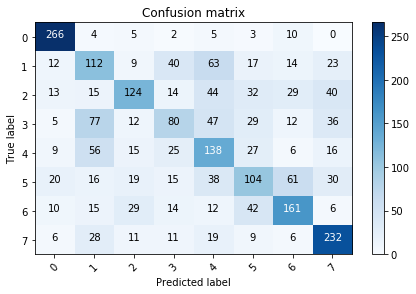

In [61]:
clf_eval(clf_rf_word2vec,
         test_features_word2vec, 
         Y_test['genero_num'], 
         classes=list(range(8)))

Como vemos acima, a performance do modelo variou muito de acordo com o gênero musical em questão. Ao transformar a variável categórica "genero" em numérica, tive o cuidado de pensar nas distâncias entre os gêneros. Ou seja, para mim, os mais distantes entre si são gospel e funk, portanto, "gospel" se tornou 0 e "funk" foi transformado em 7. 
Podemos ver que estes dois gêneros foram justamente os que apresentaram melhor resultado.

No geral, a pior performance foi do genero forró (3). De fato, suas letras podem ser facilmente confundidas com sertanejo (1), pagode (4) e até mesmo funk (7). A performance para samba (5) também não foi muito satisfatória. Acredito que isso possa ser devido ao fato de que este gênero possui aspectos musicais muito próximos da bossa nova e do pagode e, consequentemente, essa proximidade musical pode acabar se refletindo nas letras.

A performance para o pagode (4) foi bastante afetada pelo sertanejo (1). Na minha opinião, isso pode ter acontecido porque estes dois gêneros costumam tratar de temáticas muito parecidas

In [ ]:
genero_map_dict = {'gospel':0,
                   'sertanejo':1,
                   'axe':2, 
                   'forro':3, 
                   'pagode':4, 
                   'samba':5, 
                   'bossa':6,
                   'funk':7}